# Convergence analysis

How do you know if a genetic algorithm has converged? This notebook takes the results from `optimization_lake_model_dps.py` and analysis this to assess the convergence. This example ran the optimization for 5 seeds and stored all data in `./data/convergences`. 

## Creating the reference sets
The first step for asesssing the convergence is to create a reference set. The reference set is the Pareto approximate set agains which you compare. In theoretical cases, you can analytically generate the reference set. In most real cases, however, you create the reference set by combining the best results from each of the seeds and redoing an epsilon non-dominated sort.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# read all the archives
final_archives = [pd.read_csv("./data/convergences/final_archive_1760612269.4954371.csv", index_col=0),
                  pd.read_csv("./data/convergences/final_archive_1760612298.82229.csv", index_col=0),
                  pd.read_csv("./data/convergences/final_archive_1760612325.6909142.csv", index_col=0),
                  pd.read_csv("./data/convergences/final_archive_1760612351.607736.csv", index_col=0),
                  pd.read_csv("./data/convergences/final_archive_1760612379.36126.csv", index_col=0)]

In [2]:
from ema_workbench import epsilon_nondominated, Problem, RealParameter, ScalarOutcome

# specify the optimization problem
decision_variables = [RealParameter("c1", -2, 2),
                      RealParameter("c2", -2, 2),
                      RealParameter("r1", 0, 2),
                      RealParameter("r2", 0, 2),
                      RealParameter("w1", 0, 1),]
objectives = [ScalarOutcome("max_p", kind=ScalarOutcome.MINIMIZE),
              ScalarOutcome("utility", kind=ScalarOutcome.MAXIMIZE),
              ScalarOutcome("inertia", kind=ScalarOutcome.MAXIMIZE),
              ScalarOutcome("reliability", kind=ScalarOutcome.MAXIMIZE),]
problem = Problem("levers", decision_variables, objectives)

# create the reference set
reference_set = epsilon_nondominated(final_archives, [0.1]*len(objectives), problem)

## runtime information
There are two kinds of data for analysing the convergence. The first kind of data is the information collected at runtime about the progress that is being made and potentially about the behavior of the algorithm itself. In case of the dps lake problem example, we have the number of epsilon improvements by nfe, and, since we are using an auto adaptive variator, we have informatin about the probabilities of the different crossover operators. 


In [3]:
runtime_information = [pd.read_csv("./data/convergences/runtime_convergence_info_1760612269.4954371.csv", index_col=0),
                       pd.read_csv("./data/convergences/runtime_convergence_info_1760612298.82229.csv", index_col=0),
                       pd.read_csv("./data/convergences/runtime_convergence_info_1760612325.6909142.csv", index_col=0),
                       pd.read_csv("./data/convergences/runtime_convergence_info_1760612351.607736.csv", index_col=0),
                       pd.read_csv("./data/convergences/runtime_convergence_info_1760612379.36126.csv", index_col=0)]

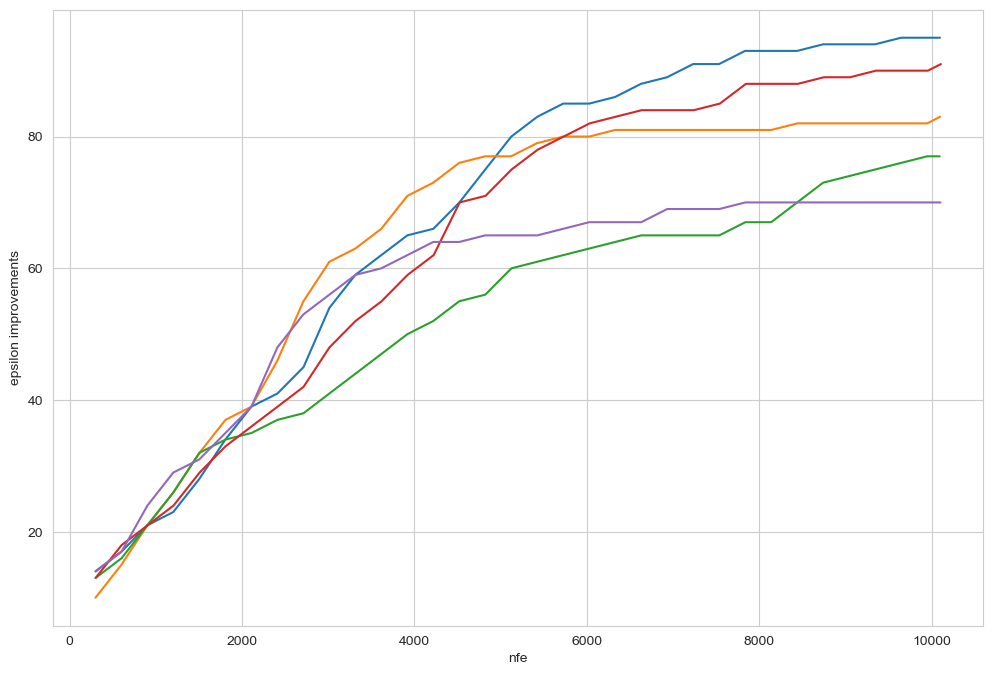

In [4]:
fig, ax = plt.subplots()

for entry in runtime_information:
    ax.plot(entry.nfe, entry. epsilon_progress)

ax.set_xlabel("nfe")
ax.set_ylabel("epsilon improvements")
plt.show()

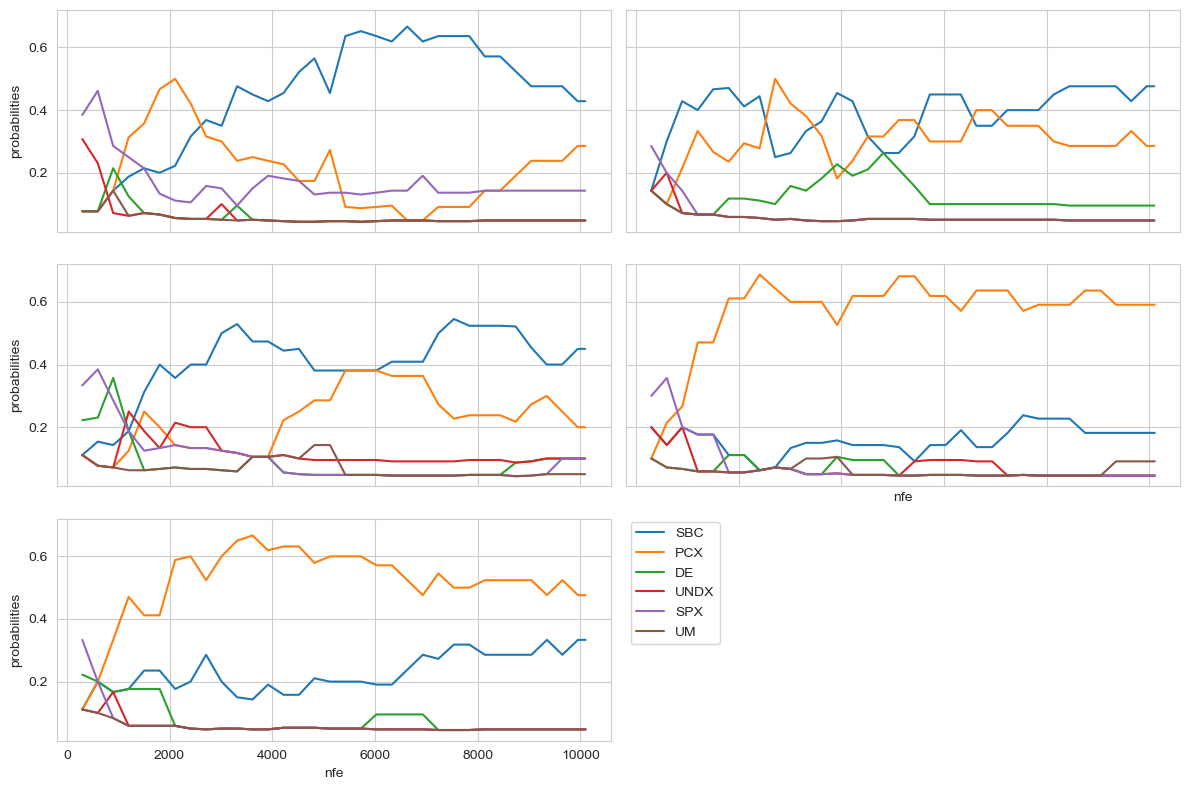

In [5]:
from matplotlib.lines import Line2D
from matplotlib.colors import TABLEAU_COLORS


fig, axes = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True)

for ax, data in zip(axes.flatten(), runtime_information):
    ax.plot(data.nfe, data.SBX, label="SBX")
    ax.plot(data.nfe, data.PCX, label="PCX")
    ax.plot(data.nfe, data.DifferentialEvolution, label="Differential Evolution")
    ax.plot(data.nfe, data.UNDX, label="UNDX")
    ax.plot(data.nfe, data.SPX, label="SPX")    
    ax.plot(data.nfe, data.UM, label="UM")

axes[-1, -1].axis("off")

colors = list(TABLEAU_COLORS.values())

custom_lines = [Line2D([0], [0], color=colors[0], label="SBC"),
                Line2D([0], [0], color=colors[1], label="PCX"),
                Line2D([0], [0], color=colors[2], label="DE"),
                Line2D([0], [0], color=colors[3], label="UNDX"),
                Line2D([0], [0], color=colors[4], label="SPX"),
                Line2D([0], [0], color=colors[5], label="UM"),]
fig.legend(handles=custom_lines, bbox_to_anchor=(0.61,0.35))

for ax in axes[:,0]:
    ax.set_ylabel("probabilities")

axes[2, 0].set_xlabel("nfe")
axes[1, 1].set_xlabel("nfe")

plt.tight_layout()
plt.show()

## Convergence metrics
The second kind of convergence analysis involves analysing the identified solutions at different points over the course of the evolutionary process. For this, we can analyse the archives that are stored in a tarball. 


In [6]:
from ema_workbench import load_archives

In [7]:
all_archives = [load_archives("./data/convergences/lake_model_dps_archive_1760612269.4954371.tar.gz"),
                load_archives("./data/convergences/lake_model_dps_archive_1760612298.82229.tar.gz"),
                load_archives("./data/convergences/lake_model_dps_archive_1760612325.6909142.tar.gz"),
                load_archives("./data/convergences/lake_model_dps_archive_1760612351.607736.tar.gz"),
                load_archives("./data/convergences/lake_model_dps_archive_1760612379.36126.tar.gz"),]

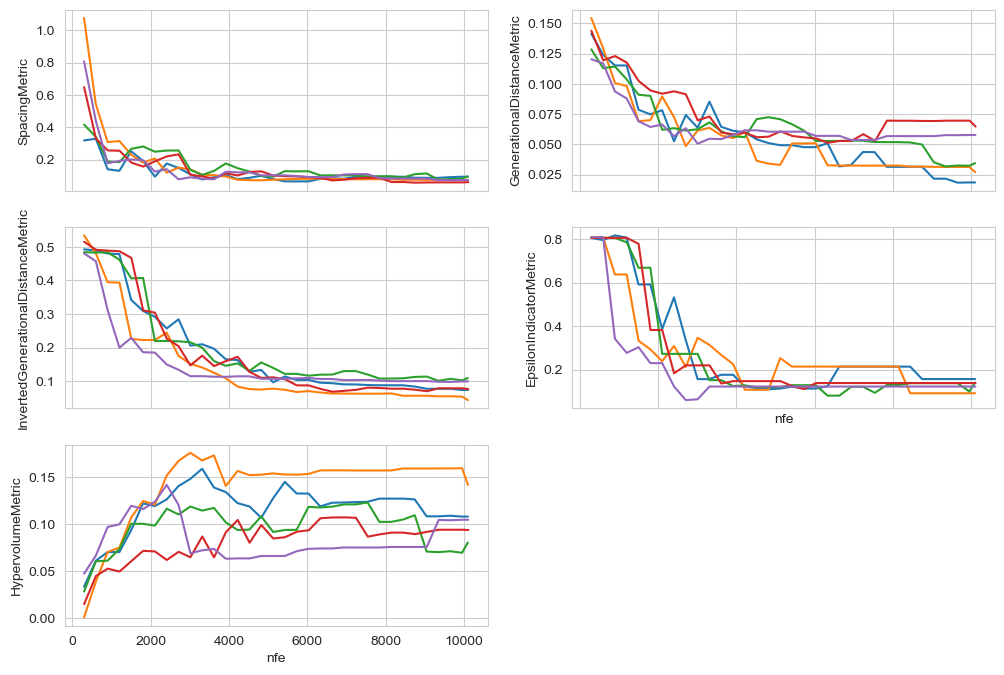

In [15]:
from ema_workbench import (SpacingMetric, GenerationalDistanceMetric, InvertedGenerationalDistanceMetric,
                           EpsilonIndicatorMetric, HypervolumeMetric)

fig, axes = plt.subplots(ncols=2, nrows=3, sharex=True)
axes[-1, -1].axis("off")

for ax, metric in zip(axes.flatten(), [SpacingMetric, GenerationalDistanceMetric, InvertedGenerationalDistanceMetric, EpsilonIndicatorMetric, HypervolumeMetric]):
    metric = metric(reference_set, problem)
    
    for entry in all_archives:
        scores = []
        for nfe, archive in entry:
            score = metric.calculate(archive)
            scores.append((nfe, score))
        
        scores = np.asarray(scores)
    
        ax.plot(scores[:, 0], scores[:,1])
    ax.set_ylabel(metric.__class__.__name__)

axes[2, 0].set_xlabel("nfe")
axes[1, 1].set_xlabel("nfe")

plt.show()

The computational cost of some of these metrics can become substantial. In particular, hypervolume scales badly with both the number of solutions in the archive and the number of objectives. The metrics used here rely on platypus-opt, which implements all metrics in pure python. However, [deap](https://deap.readthedocs.io/en/master/) ships with a hypervolume calculation implemented in C, which is substantially faster. Below is a quick illustration on how to use this implementation to produce the same results as produced by platypus. 

In [17]:
# todo
import deap

In [20]:
from deap.tools import hypervolume

In [29]:
from deap.tools._hypervolume import hv

In [37]:

def handle_directions(data, problem):
    """handle the optimization directions, and transform so all columsn reflect minimization."""
    data = data.copy()
    for i in range(data.shape[1]):
        column = data[:, i]
        if problem.directions[i] == problem.MAXIMIZE:
            data[:, i] = 1 - column
    return data

def transform_data(data, scaler, problem):
    data = data.copy()
    # setup a scaler

    # scale data
    transformed_data = scaler.transform(data)

    # handle directions
    transformed_data = handle_directions(transformed_data, problem)

    return transformed_data


# hv.hypervolume assumes minimization, so we need to transform everything accordingly
# to make life simple. we should first normalize everything on unit interval
# we need the reference point which is just the 

`hv.hypervolume(point_list, reference_point)`



In [45]:
from sklearn.preprocessing import MinMaxScaler

flat_list_of_archives = []
for archives_for_seed in all_archives:
    for (_, archive) in archives_for_seed:
        flat_list_of_archives.append(archive.iloc[:, 5::])

scaler = MinMaxScaler()
scaler.fit(pd.concat(flat_list_of_archives + [reference_set.iloc[:, 5::]]).values)     

reference_set = transform_data(reference_set.values[:, 5::], scaler, problem)
maxima = np.max(reference_set, axis=0)

In [47]:
np.min(reference_set, axis=0)

array([0.00307402, 0.01484539, 0.46072975, 0.        ])